In [6]:
!pip install yfinance
!pip install ffn
!pip install pykalman

In [179]:
import pandas as pd
import pandas_datareader as pdr
from datetime import datetime
import yfinance as yf

def get_historical_Data(tickers):
    """This function returns a pd dataframe with all of the adjusted closing information"""
    data = pd.DataFrame()
    names = list()
    for i in tickers:
        data = pd.concat([data, pd.DataFrame(yf.download(i, start=datetime(2013, 10, 27), end=datetime(2015, 12, 31)).iloc[:,4])], axis = 1)
        names.append(i)
    data.columns = names
    return data

ticks = ["DPZ", "AAPL","ADBE", "GOOG","TSLA", "AMD", "GME", "SPY", "NFLX", "BA", "WMT","GS","XOM","NKE","BRK-B", "MSFT"] #Name of company (Dominos pizza)
d = get_historical_Data(ticks)
print(d.shape)
# Most Recent Data
d.tail()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

(548, 16)


,DPZ,AAPL,ADBE,GOOG,TSLA,AMD,GME,SPY,NFLX,BA,WMT,GS,XOM,NKE,BRK-B,MSFT
Date,,,,,,,,,,,,,,,,
2015-12-23,109.349998,26.817499,94.419998,37.673500,15.478667,2.76,7.2000,204.690002,116.910004,143.080002,20.333332,180.699997,78.680000,68.120003,133.350006,55.700001
2015-12-24,109.610001,27.250000,94.449997,37.477501,15.370667,2.88,7.1550,205.720001,118.220001,143.600006,20.260000,182.270004,80.269997,64.550003,134.119995,55.860001
2015-12-28,109.669998,26.897499,93.790001,37.646000,15.432667,2.91,7.0925,204.860001,117.260002,143.259995,20.193333,181.770004,78.120003,63.209999,133.479996,55.349998
2015-12-29,110.400002,26.740000,94.599998,38.334499,15.337333,3.04,7.1550,206.509995,118.190002,145.059998,20.333332,182.820007,79.989998,64.309998,134.000000,56.290001
2015-12-30,112.410004,27.145000,95.190002,38.830002,15.773333,2.99,7.0925,207.110001,118.949997,147.220001,20.553333,183.279999,78.320000,64.360001,133.919998,56.470001


<Axes: >

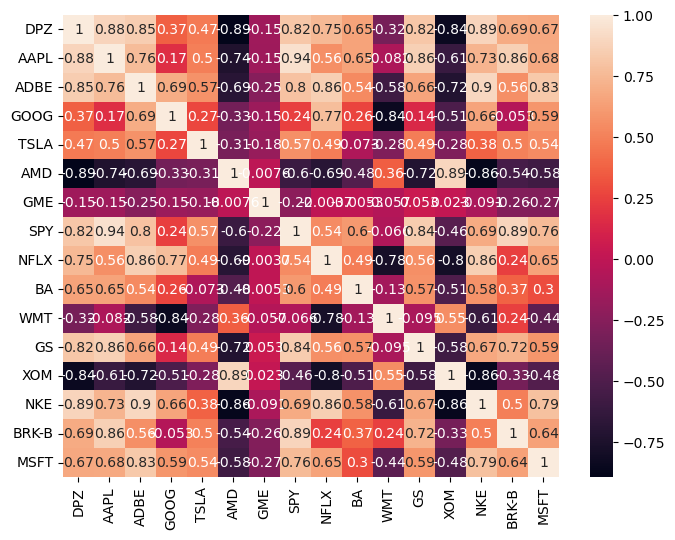

In [199]:
import seaborn as sn
corr_matrix = d.corr()
corr_matrix
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=100)
sn.heatmap(corr_matrix, annot = True)

In [181]:
# Extracting pairs with correlation > 0.95
def get_highly_correlated_pairs(corr_matrix, threshold=0.85):
    """Find pairs of tickers with correlation greater than the specified threshold."""
    pairs = []
    for i in range(len(corr_matrix)):
        for j in range(i + 1, len(corr_matrix)):
            if corr_matrix.iloc[i, j] > threshold:
                pairs.append((corr_matrix.index[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))
    return pairs

high_corr_pairs = get_highly_correlated_pairs(corr_matrix)
for pair in high_corr_pairs:
    print(f"Pair: {pair[0]} and {pair[1]}, Correlation: {pair[2]:.2f}")


Pair: DPZ and AAPL, Correlation: 0.88
Pair: DPZ and ADBE, Correlation: 0.85
Pair: DPZ and NKE, Correlation: 0.89
Pair: AAPL and SPY, Correlation: 0.94
Pair: AAPL and GS, Correlation: 0.86
Pair: AAPL and BRK-B, Correlation: 0.86
Pair: ADBE and NFLX, Correlation: 0.86
Pair: ADBE and NKE, Correlation: 0.90
Pair: AMD and XOM, Correlation: 0.89
Pair: SPY and BRK-B, Correlation: 0.89
Pair: NFLX and NKE, Correlation: 0.86


In [182]:
print(high_corr_pairs)

[('DPZ', 'AAPL', 0.8841171850731295), ('DPZ', 'ADBE', 0.8508465235734378), ('DPZ', 'NKE', 0.8871241835823017), ('AAPL', 'SPY', 0.9431379074102808), ('AAPL', 'GS', 0.8604950097787721), ('AAPL', 'BRK-B', 0.8613273941350216), ('ADBE', 'NFLX', 0.8568302178149857), ('ADBE', 'NKE', 0.9025304508552784), ('AMD', 'XOM', 0.8919868506508223), ('SPY', 'BRK-B', 0.8876895294956689), ('NFLX', 'NKE', 0.8577063875279667)]


In [183]:
import statsmodels.api as sm
import numpy as np

def find_engle_granger_cointegrated_pairs(dataframe, correlated_pairs, critical_level=0.05):
    """
    Performs the Engle-Granger test to find cointegrated pairs from a list of correlated pairs.

    Parameters:
        dataframe (pd.DataFrame): DataFrame containing the stock prices.
        correlated_pairs (list): List of tuples containing highly correlated pairs (e.g., [('AAPL', 'MSFT')]).
        critical_level (float): Threshold p-value for cointegration.

    Returns:
        pd.DataFrame: DataFrame containing cointegrated pairs and their p-values.
    """
    cointegrated_pairs = []
    
    for stock1, stock2, _ in correlated_pairs:  # Ignoring the correlation value
        # Obtain the price series for each pair
        series1 = dataframe[stock1]
        series2 = dataframe[stock2]
        
        # Perform the Engle-Granger cointegration test
        residual_model = sm.OLS(series1, sm.add_constant(series2)).fit()
        residuals = residual_model.resid
        adf_test = sm.tsa.adfuller(residuals, maxlag=1, regression='c', autolag=None)  # Augmented Dickey-Fuller test
        pvalue = adf_test[1]  # Extract the p-value from the test
        
        # Check if p-value is below the critical level
        if pvalue < critical_level:
            cointegrated_pairs.append([stock1, stock2, pvalue])
    
    return pd.DataFrame(cointegrated_pairs, columns=['S1', 'S2', 'Pvalue'])

# Example usage:
correlated_pairs = get_highly_correlated_pairs(corr_matrix)  # From previous step
cointegrated_pairs = find_engle_granger_cointegrated_pairs(d, correlated_pairs)

print(cointegrated_pairs)

     S1    S2    Pvalue
0  AAPL   SPY  0.002840
1  ADBE  NFLX  0.037055
2  ADBE   NKE  0.017212
3   AMD   XOM  0.020291


C:\Users\shubh\AppData\Local\Temp\ipykernel_35728\1073493333.py:56: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df1['num units long'][0] = 0
C:\Users\shubh\AppData\Local\Temp\ipykernel_35728\1073493333.py:56: SettingWithCopyWarning: 
A val

Overall Total PnL: 165.45264877777808
Average Sharpe Ratio: nan


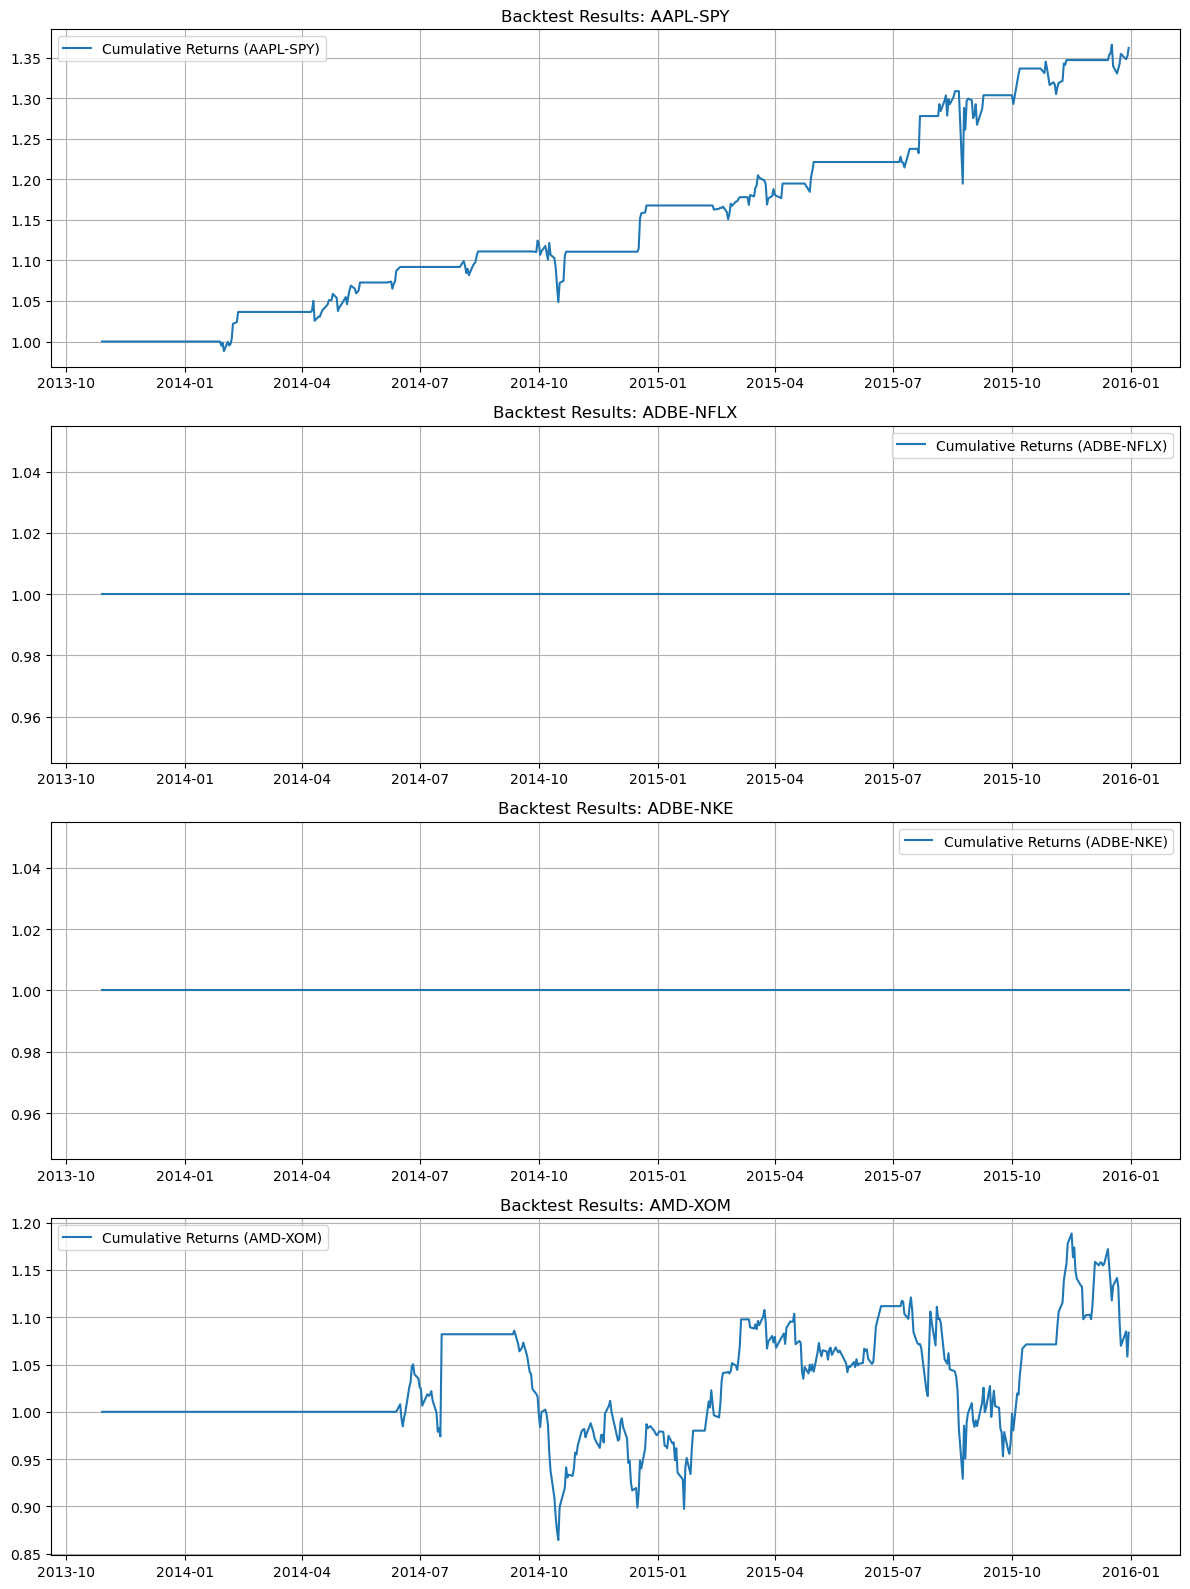


Performance Metrics for Each Pair:
        Pair  Sharpe Ratio   Total PnL
0   AAPL-SPY      1.160363  147.739326
1  ADBE-NFLX           NaN    0.000000
2   ADBE-NKE           NaN    0.000000
3    AMD-XOM      0.189253   17.713322


In [184]:
from pykalman import KalmanFilter
import numpy as np
import pandas as pd
from math import sqrt
import matplotlib.pyplot as plt

def KalmanFilterAverage(x):
    kf = KalmanFilter(transition_matrices=[1],
                      observation_matrices=[1],
                      initial_state_mean=0,
                      initial_state_covariance=1,
                      observation_covariance=1,
                      transition_covariance=0.01)
    state_means, _ = kf.filter(x.values)
    return pd.Series(state_means.flatten(), index=x.index)

def KalmanFilterRegression(x, y):
    delta = 1e-3
    trans_cov = delta / (1 - delta) * np.eye(2)
    obs_mat = np.expand_dims(np.vstack([x, np.ones(len(x))]).T, axis=1)
    kf = KalmanFilter(n_dim_obs=1, n_dim_state=2,
                      initial_state_mean=[0, 0],
                      initial_state_covariance=np.ones((2, 2)),
                      transition_matrices=np.eye(2),
                      observation_matrices=obs_mat,
                      observation_covariance=2,
                      transition_covariance=trans_cov)
    state_means, _ = kf.filter(y.values)
    return state_means

def half_life(series):
    lagged = series.shift(1).dropna()
    delta = series.diff().dropna()
    beta = np.polyfit(lagged, delta, 1)[0]
    halflife = -np.log(2) / beta
    return int(max(halflife, 1))

def backtest(s1, s2, x, y):
    df1 = pd.DataFrame({'y': y, 'x': x})
    state_means = KalmanFilterRegression(KalmanFilterAverage(x), KalmanFilterAverage(y))
    df1['hr'] = -state_means[:, 0]
    df1['spread'] = df1.y - (df1.x * df1.hr)

    halflife = half_life(df1['spread'])
    meanSpread = df1.spread.rolling(window=halflife).mean()
    stdSpread = df1.spread.rolling(window=halflife).std()
    df1['zScore'] = (df1.spread - meanSpread) / stdSpread

    entryZscore = 2
    exitZscore = 0
    df1['long entry'] = ((df1.zScore < -entryZscore) & (df1.zScore.shift(1) > -entryZscore))
    df1['long exit'] = ((df1.zScore > -exitZscore) & (df1.zScore.shift(1) < -exitZscore))
    df1['num units long'] = np.nan
    df1.loc[df1['long entry'], 'num units long'] = 1
    df1.loc[df1['long exit'], 'num units long'] = 0
    df1['num units long'][0] = 0
    df1['num units long'] = df1['num units long'].fillna(method='pad')

    df1['short entry'] = ((df1.zScore > entryZscore) & (df1.zScore.shift(1) < entryZscore))
    df1['short exit'] = ((df1.zScore < exitZscore) & (df1.zScore.shift(1) > exitZscore))
    df1['num units short'] = np.nan
    df1.loc[df1['short entry'], 'num units short'] = -1
    df1.loc[df1['short exit'], 'num units short'] = 0
    df1['num units short'][0] = 0
    df1['num units short'] = df1['num units short'].fillna(method='pad')

    df1['numUnits'] = df1['num units long'] + df1['num units short']
    df1['spread pct ch'] = (df1['spread'] - df1['spread'].shift(1)) / ((df1['x'] * abs(df1['hr'])) + df1['y'])
    df1['port rets'] = df1['spread pct ch'] * df1['numUnits'].shift(1)

    df1['cum rets'] = df1['port rets'].cumsum() + 1

    # Calculate PnL
    df1['PnL'] = df1['port rets'] * ((df1['x'] * abs(df1['hr'])) + df1['y'])
    total_pnl = df1['PnL'].sum()

    try:
        sharpe = ((df1['port rets'].mean() / df1['port rets'].std()) * sqrt(252))
    except ZeroDivisionError:
        sharpe = 0.0

    return df1['cum rets'], sharpe, df1['PnL'], total_pnl

# Perform Backtests for All Pairs
total_pnls = []
sharpe_ratios = []
cumulative_returns_all = pd.DataFrame()
pair_results = []

for _, pair in cointegrated_pairs.iterrows():
    s1, s2 = pair['S1'], pair['S2']
    cum_rets, sharpe, pnl, total_pnl = backtest(s1, s2, d[s1], d[s2])
    
    # Store individual pair results
    pair_results.append({'Pair': f"{s1}-{s2}", 'Sharpe Ratio': sharpe, 'Total PnL': total_pnl})
    total_pnls.append(total_pnl)
    sharpe_ratios.append(sharpe)
    cumulative_returns_all[f"{s1}-{s2}"] = cum_rets

# Aggregate Results
overall_total_pnl = sum(total_pnls)
average_sharpe_ratio = np.mean(sharpe_ratios)

print(f"Overall Total PnL: {overall_total_pnl}")
print(f"Average Sharpe Ratio: {average_sharpe_ratio}")

# Plot Results for Each Pair
num_pairs = len(cointegrated_pairs)
fig, axes = plt.subplots(num_pairs, 1, figsize=(12, 4 * num_pairs))

if num_pairs == 1:
    axes = [axes]  # Ensure axes is iterable for a single subplot case

for ax, pair, cum_rets in zip(axes, cointegrated_pairs.itertuples(), cumulative_returns_all.columns):
    ax.plot(cumulative_returns_all[cum_rets], label=f'Cumulative Returns ({pair.S1}-{pair.S2})')
    ax.set_title(f"Backtest Results: {pair.S1}-{pair.S2}")
    ax.legend()
    ax.grid()

plt.tight_layout()
plt.show()

# Display Performance Metrics for Each Pair
pair_results_df = pd.DataFrame(pair_results)
print("\nPerformance Metrics for Each Pair:")
print(pair_results_df)
